In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
%run scripts/helper.py

In [4]:
otto_train = load_csv('./train.csv/train.csv', 'id'); otto_train.shape

(61878, 94)

In [5]:
otto_X = otto_train[otto_train.columns[:-1]]
otto_Y = otto_train.target

In [55]:
otto_X_small, otto_Y_small = get_smaller_dataset(otto_X, otto_Y, 1500)

In [56]:
otto_X_small.shape, otto_Y_small.shape

((1500, 93), (1500,))

### Support Vector Machines

In [7]:
from sklearn.svm import SVC

In [8]:
model = SVC(probability=True).fit(otto_X_small.values, otto_Y_small.values)

In [9]:
from sklearn.metrics import log_loss
print 'Log loss score on the training set is %f' %(log_loss(otto_Y_small, model.predict_proba(otto_X_small)))

Log loss score on the training set is 0.367880


#### This is the training set log loss score we obtain when we feed the attributes as such without any preprocessing and parameter-tuning

In [10]:
# lets implement basic cross-validation
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        otto_X_small, otto_Y_small, test_size=0.2, random_state=12)

In [11]:
print ("train data shape: %r, train target shape: %r"
      %(X_train.shape, y_train.shape))

print ("test data shape: %r, test target shape: %r"
      %(X_test.shape, y_test.shape))

train data shape: (4000, 93), train target shape: (4000,)
test data shape: (1000, 93), test target shape: (1000,)


In [12]:
svc = SVC().fit(X_train, y_train)
train_score = svc.score(X_train, y_train)
train_score

0.86399999999999999

In [13]:
test_score = svc.score(X_test, y_test)
test_score

0.71699999999999997

### The model is overfitting.

In [14]:
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [57]:
X = otto_X_small.values
y = otto_Y_small.values

n_samples = X.shape[0]

In [42]:
from sklearn.cross_validation import ShuffleSplit

cv = ShuffleSplit(n_samples, n_iter=3, test_size=0.1,
    random_state=0)

for cv_index, (train, test) in enumerate(cv):
    print("# Cross Validation Iteration #%d" % cv_index)
    print("train indices: {0}...".format(train[:10]))
    print("test indices: {0}...".format(test[:10]))
    
    svc = GradientBoostingClassifier(n_estimators=100, max_depth=5, max_features='auto').fit(X[train], y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(X[train], y[train]), svc.score(X[test], y[test])))

# Cross Validation Iteration #0
train indices: [785 873  65 902 317 636 666 789 958 214]...
test indices: [993 859 298 553 672 971  27 231 306 706]...
train score: 1.000, test score: 0.730

# Cross Validation Iteration #1
train indices: [361 876 105 297 135 352 729  77 839   9]...
test indices: [ 18 939 532 671 506 276 601 845 386 201]...
train score: 1.000, test score: 0.720

# Cross Validation Iteration #2
train indices: [677 436 909 416  69 764 872 388  96 911]...
test indices: [947 842 500 489 680 181 676  71  70 222]...
train score: 1.000, test score: 0.670



In [26]:
n_gammas = 3
n_iter = 5
cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=500, test_size=500,
    random_state=0)

train_scores = np.zeros((n_gammas, n_iter))
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(1, 3, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train, test) in enumerate(cv):
        clf = GradientBoostingClassifier(n_estimators=int(gamma)).fit(X[train], y[train])
        train_scores[i, j] = clf.score(X[train], y[train])
        test_scores[i, j] = clf.score(X[test], y[test])

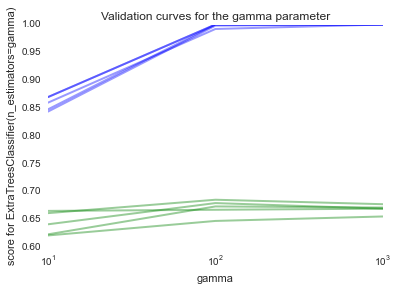

In [27]:
def plot_validation_curves(param_values, train_scores, test_scores):
    for i in range(train_scores.shape[1]):
        plt.semilogx(param_values, train_scores[:, i], alpha=0.4, lw=2, c='b')
        plt.semilogx(param_values, test_scores[:, i], alpha=0.4, lw=2, c='g')

plot_validation_curves(gammas, train_scores, test_scores)
plt.ylabel("score for ExtraTreesClassifier(n_estimators=gamma)")
plt.xlabel("gamma")
# plt.text(1e-6, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
# plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
# plt.text(1e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.title('Validation curves for the gamma parameter');

### Learning curves

In [58]:
train_sizes = np.logspace(2, 3, 5).astype(np.int)
train_sizes

array([ 100,  177,  316,  562, 1000])

In [59]:
n_iter = 5
train_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)
test_scores = np.zeros((train_sizes.shape[0], n_iter), dtype=np.float)

In [60]:
clf = GradientBoostingClassifier(n_estimators=100, max_depth=5)

for i, train_size in enumerate(train_sizes):
    cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=train_size)
    for j, (train, test) in enumerate(cv):
        clf.fit(X[train], y[train])
        train_scores[i, j] = clf.score(X[train], y[train])
        test_scores[i, j] = clf.score(X[test], y[test])

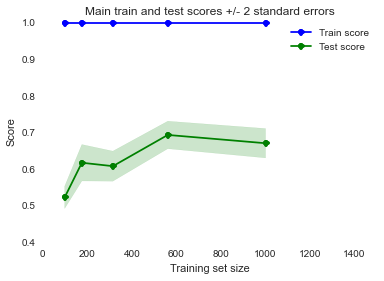

In [61]:
from scipy.stats import sem

mean_train = np.mean(train_scores, axis=1)
confidence = sem(train_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_train - confidence,
                 mean_train + confidence,
                 color = 'b', alpha = .2)
plt.plot(train_sizes, mean_train, 'o-k', c='b', label='Train score')

mean_test = np.mean(test_scores, axis=1)
confidence = sem(test_scores, axis=1) * 2

plt.fill_between(train_sizes,
                 mean_test - confidence,
                 mean_test + confidence,
                 color = 'g', alpha = .2)
plt.plot(train_sizes, mean_test, 'o-k', c='g', label='Test score')

plt.xlabel('Training set size')
plt.ylabel('Score')
plt.xlim(0, X.shape[0])
plt.ylim((None, 1.01))  # The best possible score is 1.0
plt.legend(loc='best')

# plt.text(250, 0.9, "Overfitting a lot", fontsize=16, ha='center', va='bottom')
# plt.text(800, 0.9, "Overfitting a little", fontsize=16, ha='center', va='bottom')
plt.title('Main train and test scores +/- 2 standard errors');